In [75]:
import pandas as pd
import numpy as np
import time

In [76]:
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.graph_objs as go
from plotly.offline import iplot

In [77]:
def MAPE(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def RMSE(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

def calcError(origin, forecast):
    print("RMSE", RMSE(origin, forecast))
    print("MAPE", MAPE(origin, forecast))

In [78]:
def showPlot(true, prediction, model , test_set, size='M', save=False):
    if(size=='L'):
        plt.figure(figsize=(28, 10))
    plt.plot(true, color = 'red', label = 'Real')
    plt.plot(prediction, color = 'blue', label = 'Prediction')
    plt.title('Industry Elec Prediction' + model + ' ' + test_set + ' t' + str(t))
    plt.xlabel('Time')
    plt.ylabel('kW')
    plt.legend()
    if(save):
        plt.savefig('Image/' + model + '-' + test_set + '-' + str(t) + '.png')
    plt.show()

In [79]:
def augFeatures(data, features_select):
    data = pd.DataFrame(data[features_select])
    data.shape
    return data

In [80]:
from sklearn.preprocessing import MinMaxScaler
def normalize(data):
    sc = MinMaxScaler(feature_range = (0, 1))
    data_scaled = pd.DataFrame(sc.fit_transform(data))
    return sc, data_scaled 

def deNormalize(sc, value):
    value_unscaled = value * (sc.data_max_[0]-sc.data_min_[0]) + sc.data_min_[0]
    return value_unscaled 

In [81]:
def split_dataset(data, pastDay=7, futureDay=7):
    split_num_start = df[df['Date'] == trainFrom].index.item()
    split_num = df[df['Date'] == testFrom].index.item()
    split_num_end = df[df['Date'] == testTo].index.item()
    RawTrain = data[split_num_start:split_num]
    SelfTest = data[split_num_start:split_num - futureDay]
    SelfTruth = data[split_num_start + pastDay:split_num][0]
    RawTest = data[split_num - pastDay:split_num_end + 1 - futureDay]
    RawTrurh = data[split_num:split_num_end + 1][0]
    print("RawTrain", RawTrain.shape)
    print("RawTest, RawTrurh", RawTest.shape, RawTrurh.shape)
    print("SelfTest, SelfTruth", SelfTest.shape, SelfTruth.shape)
    return RawTrain, RawTest, RawTrurh, SelfTest, SelfTruth

In [82]:
def buildTrain(train, pastDay=7, futureDay=7):
    X_train, Y_train = [], []
    for i in range(pastDay, len(train)-futureDay):
        X_train.append(train[i-pastDay:i])
        Y_train.append(train[i:i+futureDay, 0])
    X_train, Y_train = np.array(X_train), np.array(Y_train)  
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
    return X_train, Y_train

In [83]:
def buildTest(test, pastDay=7, futureDay=7):
    X_test = []
    for i in range(0, int(len(test)/futureDay)-(pastDay-futureDay)):
        X_test.append(test[futureDay*i:futureDay*i+pastDay])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))  
    return X_test

In [84]:
def forecast(model, input_data, shape):
    forecast_temp = model.predict(input_data)
    forecast = []
    for i in range(forecast_temp.shape[0]):
        forecast= np.concatenate((forecast, forecast_temp[i]), axis=0)
    forecast = np.reshape(forecast, (shape[0], shape[1]))
    return forecast

In [85]:
from hyperopt import Trials, STATUS_OK, tpe
from hyperas import optim
from hyperas.distributions import choice, uniform

In [86]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
from keras.models import Sequential
from keras.layers import Dense, TimeDistributed, Flatten, RepeatVector
from keras.layers import SimpleRNN, LSTM, CuDNNLSTM
from keras.layers import Dropout, BatchNormalization, Bidirectional
from keras import optimizers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [87]:
def create_model(X, Y, Xv, Yv):
    epochs = 10000
    model = Sequential()
    model.add(SimpleRNN(units = {{choice([50,100,150,200,250,300,500])}}, activation='relu', input_shape = (X.shape[1], X.shape[2])))
    model.add(RepeatVector(7))
    model.add(SimpleRNN({{choice([50,100,150,200,250,300,500])}}, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense({{choice([50,100,150,200,250,300,500])}}, activation='relu')))
    model.add(Dropout({{uniform(0, 1)}}))
    model.add(Flatten())
    model.add(Dense(units = 7))
    model.compile(loss='mse', optimizer='adam')
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=15, mode='min', verbose=0)
    earlyStop=EarlyStopping(monitor="val_loss", patience=20, mode="min", restore_best_weights=True)
    model.fit(X, Y, 
              epochs=epochs, batch_size={{choice([16, 32, 64, 96, 128])}}, 
              verbose=0, 
              validation_data=(Xv, Yv), 
              callbacks=[reduce_lr, earlyStop])
    return {'loss': min(model.history.history['val_loss']), 'status': STATUS_OK, 'model': model}

In [88]:
def data():
    def augFeatures(data, features_select):
        data = pd.DataFrame(data[features_select])
        data.shape
        return data
    def normalize(data):
        sc = MinMaxScaler(feature_range = (0, 1))
        data_scaled = pd.DataFrame(sc.fit_transform(data))
        return sc, data_scaled 
    def deNormalize(sc, value):
        value_unscaled = value * (sc.data_max_[0]-sc.data_min_[0]) + sc.data_min_[0]
        return value_unscaled 
    def split_dataset(data, pastDay=7, futureDay=7):
        split_num_start = df[df['Date'] == trainFrom].index.item()
        split_num = df[df['Date'] == testFrom].index.item()
        split_num_end = df[df['Date'] == testTo].index.item()
        RawTrain = data[split_num_start:split_num]
        SelfTest = data[split_num_start:split_num - futureDay]
        SelfTruth = data[split_num_start + pastDay:split_num][0]
        RawTest = data[split_num - pastDay:split_num_end + 1 - futureDay]
        RawTrurh = data[split_num:split_num_end + 1][0]
        print("RawTrain", RawTrain.shape)
        print("RawTest, RawTrurh", RawTest.shape, RawTrurh.shape)
        print("SelfTest, SelfTruth", SelfTest.shape, SelfTruth.shape)
        return RawTrain, RawTest, RawTrurh, SelfTest, SelfTruth
    def splitData(X, Y, rate):
        X_train = X[int(X.shape[0]*rate):]
        Y_train = Y[int(Y.shape[0]*rate):]
        X_val = X[:int(X.shape[0]*rate)]
        Y_val = Y[:int(Y.shape[0]*rate)]
        return X_train, Y_train, X_val, Y_val
    def buildTrain(train, pastDay=7, futureDay=7):
        X_train, Y_train = [], []
        for i in range(pastDay, len(train)-futureDay):
            X_train.append(train[i-pastDay:i])
            Y_train.append(train[i:i+futureDay, 0])
        X_train, Y_train = np.array(X_train), np.array(Y_train)  
        X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
        return X_train, Y_train
    features = [
            'kW', 
            'PeakLoad(MW)_shift7', 
            'isHoliday_shift7', 
            'dayOfYear', 
            'weekUpdate_shift7', 
            'Temp_Taipei_shift7'
           ]
    trainFrom = '2017-01-04'
    trainTo = '2019-01-01'
    testFrom = '2019-01-02'
    testTo = '2019-09-24'
    df = pd.read_csv('Data/industryElec_processed_20160101_20190930.csv')
    df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
    RawData = augFeatures(df, features)
    sc, RawData = normalize(RawData)
    Timesteps = 7
    OutputDay = 7
    RawTrain, RawTest, RawTrurh, SelfTest, SelfTruth  = split_dataset(RawData, Timesteps, OutputDay)
    X_train, Y_train = buildTrain(RawTrain.values, Timesteps, OutputDay)
    X, Y, Xv, Yv= splitData(X_train, Y_train, 0.1)
    return X, Y, Xv, Yv

In [89]:
tStart = time.time()

X, Y, Xv, Yv = data()

best_run, best_model = optim.minimize(model=create_model,
                                      data=data,
                                      algo=tpe.suggest,
                                      max_evals=30,
                                      trials=Trials(),
                                      verbose=False,
                                      notebook_name='IndustryElec_(RNN_XT)_Hyperas')

print("Evalutation of best performing model:")
print(best_model.evaluate(Xv, Yv))
print(best_run)

tEnd = time.time()
print('Total time spent.....',tEnd - tStart, 'second')

RawTrain (728, 6)
RawTest, RawTrurh (266, 6) (266,)
SelfTest, SelfTruth (721, 6) (721,)


UnicodeDecodeError: 'cp950' codec can't decode byte 0xe2 in position 11319: illegal multibyte sequence

In [64]:
best_model.save('Best_Model_RNN_1.h5')

In [65]:
features = [
            'kW', 
            'PeakLoad(MW)_shift7', 
            'isHoliday_shift7', 
            'dayOfYear', 
            'weekUpdate_shift7', 
            'Temp_Taipei_shift7'
           ]
trainFrom = '2017-01-04'
trainTo = '2019-01-01'
testFrom = '2019-01-02'
testTo = '2019-09-24'
df = pd.read_csv('Data/industryElec_processed_20160101_20190930.csv')
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

RawData = augFeatures(df, features)
sc, RawData = normalize(RawData)

Timesteps = 7
OutputDay = 7

RawTrain, RawTest, RawTrurh, SelfTest, SelfTruth  = split_dataset(RawData, Timesteps, OutputDay)

X_train, Y_train = buildTrain(RawTrain.values, Timesteps, OutputDay)
S_test = buildTest(SelfTest.values, Timesteps, OutputDay)
X_test = buildTest(RawTest.values, Timesteps, OutputDay)

RawTrain (728, 6)
RawTest, RawTrurh (266, 6) (266,)
SelfTest, SelfTruth (721, 6) (721,)


In [71]:
t = 2
save = True
model_name = '(XT_RNN_2017_Hyperas)'

RMSE 5.48142154317909
MAPE 1.3228581437450624


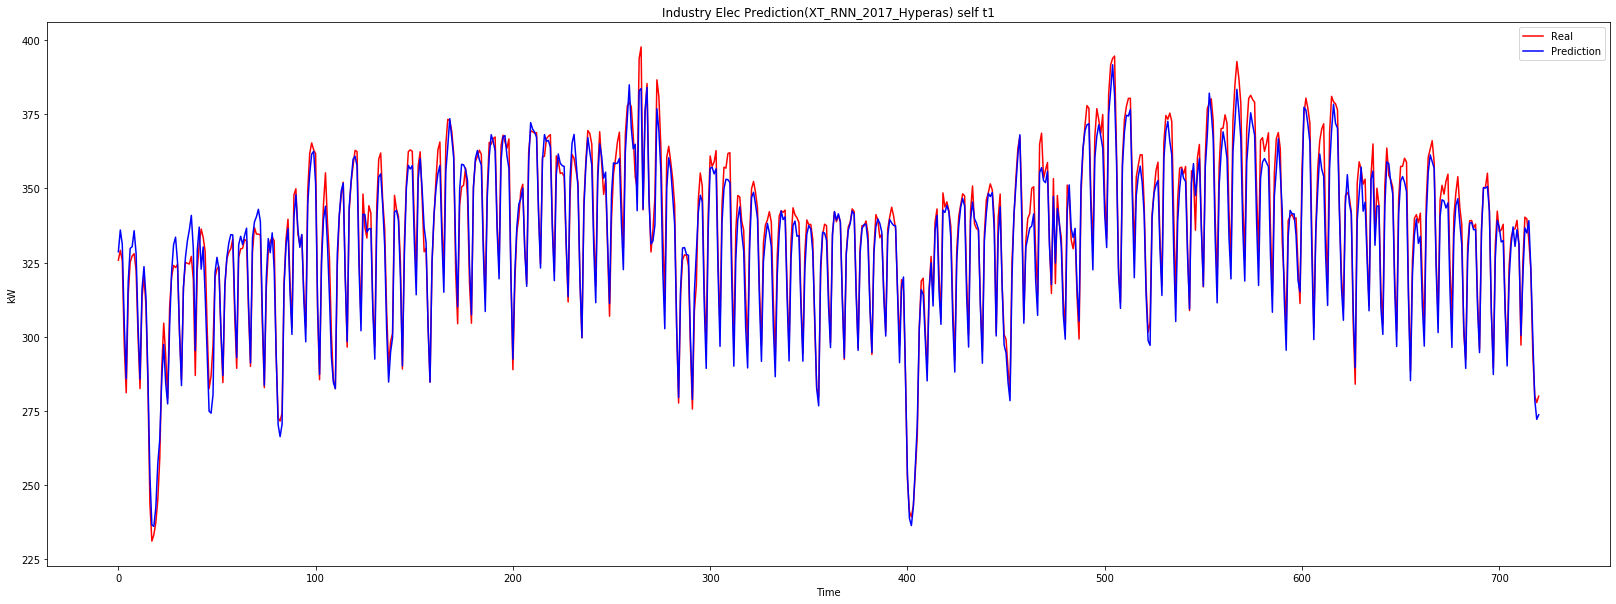

In [73]:
self_trurh = pd.DataFrame(SelfTruth)
self_trurh = deNormalize(sc, self_trurh.values)
self_predict = forecast(best_model, S_test, self_trurh.shape)
self_predict = deNormalize(sc, self_predict)
calcError(self_trurh, self_predict)
showPlot(self_trurh, self_predict, model_name , "self", size="L", save=save)

RMSE 9.525067144994644
MAPE 2.1759155051121386


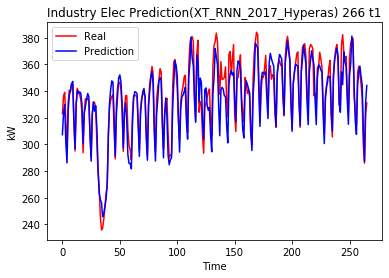

In [74]:
test_trurh = pd.DataFrame(RawTrurh)
test_trurh = deNormalize(sc, test_trurh.values)
test_predict = forecast(best_model, X_test, test_trurh.shape)
test_predict = deNormalize(sc, test_predict)
calcError(test_trurh, test_predict)
showPlot(test_trurh, test_predict, model_name , str(266), save=save)